# Q Transform with Amplitude Modulation - Example Usage

We download a series of packages needed to download a gravitational wave and process it.

In [67]:
from gwosc.datasets import event_gps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import sys
import importlib

import matplotlib.pyplot as plt
import torch

from gwpy.timeseries import TimeSeries

from torchaudio import *
import pandas as pd

Work with GPU if possible

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"

We download a ten-seconds time series containing a the GW event GW150914-v3.

In [3]:
event='GW150914-v3'
event_label='GW150914'
gps=event_gps(event)
dets=['L1','H1']
dets_label=['LIGO Livingston (L1)','LIGO Hanford (H1)']
ncols=len(dets)
nrows=3

denoising_threshold=7.
energy_density_threshold=7.

In [4]:
f_s=4096
f_range=[20., 2048.]
filmethod='highpass_threshold_filtering' 

In [5]:
detector=dets[1] # select the Hanford observatory

delta=.375 #the size of delta determines the total lengh of the time interval, which will be 2*delta
segment=(gps-5, gps+5) #choose an interval centred at the detection time
data_init = TimeSeries.fetch_open_data(detector, *segment, verbose=True) # download data
tensor_data=torch.tensor(data_init) #convert data to PyTorch tensor

Fetched 1 URLs from gwosc.org for [1126259457 .. 1126259468))
Reading data... [Done]


In [6]:
original_sample_rate=int(len(data_init)/(segment[1]-segment[0]))
transform = transforms.Resample(original_sample_rate, f_s, dtype=torch.float64)

data=transform(tensor_data).to(device) #resample the data to f_s
times=np.arange(segment[0], segment[-1], 1./f_s)
original_duration=data.shape[0]/f_s

For the un-whitened data a lower frequency dominates and hides the gravitational wave.

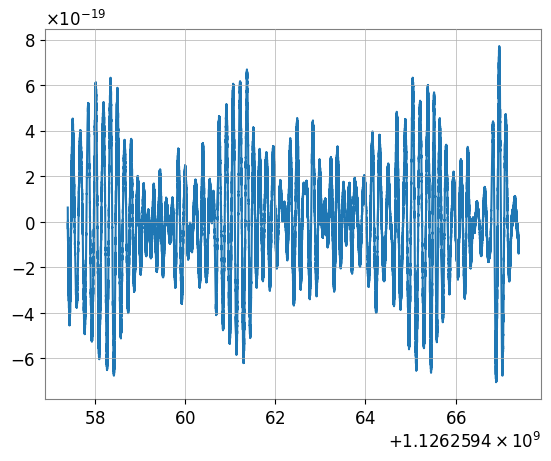

In [7]:
plt.plot(times, data.detach().cpu())

From the Annalisa package we download the STFTWhiten class which we use to whiten the data.

In [8]:
#sys.path.insert(1, '../' )
#importlib.reload(sys.modules['Annalisa_gpu_2_1_0'])
from Annalisa_gpu_2_1_0 import *
importlib.reload(sys.modules['Annalisa_gpu_2_1_0'])

NVIDIA GH200 480GB
Running on device: device='cuda'
NVIDIA GH200 480GB
Running on device: device='cuda'


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'Annalisa_gpu_2_1_0' from '/workspace/notebooks_intertwin/Francesco/Annalisa_gpu_2_1_0.py'>

In [9]:
try:
    del whitener
    torch.cuda.empty_cache()
except:
    pass

whitener = STFTWhiten(
    duration=original_duration,
    psd_nfft=8192, 
    psd_win_length=8192, 
    psd_hop_length=128,
    # Parameters for whitening STFT:
    stft_nfft=8192,
    stft_win_length=8192,
    stft_hop_length=512,  #1024
    stft_window_type='hann', 
    sample_rate=f_s,
    center=True, 
    normalized='energy',
    average_type='median',   # Options: None, 'mean', 'median', 'moving_mean', 'moving_median'
    normalization='ml4gw',   # Options: 'ml4gw', 'nperseg', 'window_sum', 'fftlength', None
    moving_avg_window_ratio=0.2,  
    epsilon=1.0e-31,#1.0e-21,#1.0e-12,              
    # Border mitigation options:
    exclude_border=False,       # Exclude border frames in PSD estimation.
    border_fraction=1/3,       # Fraction of frames to exclude at each end.
    border_mitigation=True,    
    pad_mode="constant",
    # Synthesis window compensation option:
    design_synth_window=True,
    # New window options for PSD and STFT:
    psd_window_type='hann',
    psd_planck_epsilon=0.5,
    psd_kaiser_beta=100,
    truncation_window_type='hann',
    truncation_planck_epsilon=0.5,
    truncation_kaiser_beta=4,
    detrend=True,
#    truncation_window_size=0.04,
    convolve_method='overlapsave'  #'overlapsave' 'stft'
).to(device)

In [10]:
GW_whitened=whitener(data.unsqueeze(0).unsqueeze(0))

x.shape=torch.Size([1, 1, 40960])
x.shape=torch.Size([1, 1, 68266])
pad=4096
pad=4096


We then crop an interval of 0.2 seconds around the recorded GPS time of the wave. We plot the Time Series of the wave.

In [11]:
start_time=.15
end_time=.05
GW_whitened=GW_whitened[0][0][int(len(GW_whitened[0][0])/2)-int(start_time*f_s):int(len(GW_whitened[0][0])/2)+int(end_time*f_s)]
times=np.arange(gps-start_time, gps+end_time, 1./f_s)
times=times[:-1]
duration=GW_whitened.shape[0]/f_s

In [12]:
torch.save(GW_whitened, 'GW150914_Whitened.pt')

In [69]:
GW_whitened=torch.load('GW150914_Whitened.pt')

After the whitening, the gravitational wave is more visible.

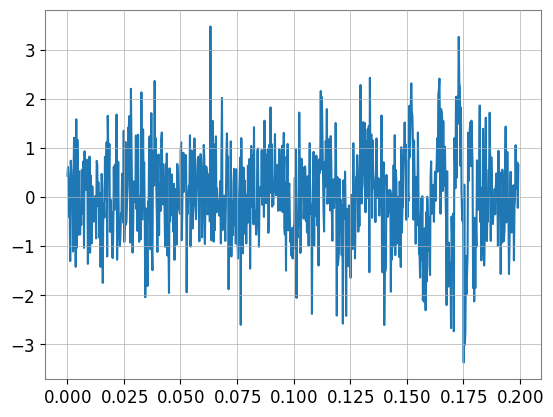

In [70]:
times=np.arange(0., duration, 1./f_s)
plt.plot(times,np.array(GW_whitened.detach().cpu()))

In [71]:
f_s=4096
Q=12
f_range=[20., 2048.]
duration=GW_whitened.shape[-1]/f_s

In [72]:
sys.path.insert(1, '../')
from qtransform_gpu_2_5_0 import *
importlib.reload(sys.modules['qtransform_gpu_2_5_0'])
from qtransform_gpu_2_5_0 import *

In [73]:
normalize=False
energy_mode=True 
phase_mode=True
interp_mode=None #'fourier' #None
polar_mode=True 
complex_mode=False

In [103]:
qtransform = SingleQTransform(
     duration=duration,
     sample_rate=f_s,     
     q=Q,
     frange=f_range,
     logf=True,
     num_freq=64, 
     max_window_size=False
 )


start=time.time()
energy_polar=qtransform(GW_whitened, 
                        normalize=normalize,
                        energy_mode=energy_mode,
                        phase_mode=phase_mode,
                        interp_mode=interp_mode,
                        polar_mode=polar_mode,
                        complex_mode=complex_mode,
                        spectrogram_shape=[64,64],
                        num_time=None).to('cpu')
print(time.time()-start)

0.011425256729125977


In [75]:
energy=energy_polar.clone()

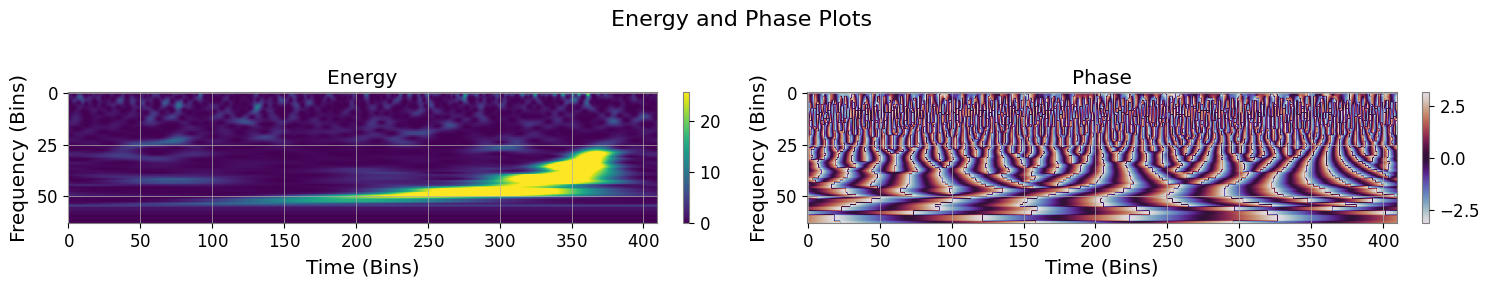

In [76]:
num_plots = energy.shape[0] 
# Create figure with num_plots rows and 2 columns. Increased figsize width for two plots side-by-side.
fig, axes = plt.subplots(num_plots, 2, figsize=(15, 3 * num_plots)) 

# Set common visualization limits
vmax_energy = 25.5
vmin_energy = 0
vmax_phase = np.pi
vmin_phase = -np.pi

# Handle the case where there is only 1 row (axes might be 1D, so reshape to [1, 2])
if num_plots == 1:
    axes = np.array([axes])
# axes now has shape [num_plots, 2]

for i in range(num_plots):
    
    # --- 1. Energy Plot (Column 0) ---
    ax_energy = axes[i, 0]
    # Slicing for Energy/Magnitude: [i, 0, 0]
    data_energy = energy[i, 0, 0] 
    title_energy = 'Energy'

    im_energy = ax_energy.imshow(
        np.flipud(data_energy.cpu().numpy()), 
        aspect='auto', 
        vmin=vmin_energy, 
        vmax=vmax_energy, 
        cmap='viridis'
    )
    ax_energy.set_title(title_energy)
    ax_energy.set_xlabel('Time (Bins)')
    ax_energy.set_ylabel('Frequency (Bins)')
    # Add colorbar for energy plot
    fig.colorbar(im_energy, ax=ax_energy, fraction=0.046, pad=0.04) 

    # --- 2. Phase Plot (Column 1) ---
    ax_phase = axes[i, 1]
    # Slicing for Phase: [i, 0, 1]
    data_phase = energy[i, 0, 1] 
    title_phase = 'Phase'

    im_phase = ax_phase.imshow(
        np.flipud(data_phase.cpu().numpy()), 
        aspect='auto', 
        vmin=vmin_phase, 
        vmax=vmax_phase, 
        cmap='twilight' # 'twilight' is excellent for circular data like phase
    )
    ax_phase.set_title(title_phase)
    ax_phase.set_xlabel('Time (Bins)')
    ax_phase.set_ylabel('Frequency (Bins)')
    # Add colorbar for phase plot
    fig.colorbar(im_phase, ax=ax_phase, fraction=0.046, pad=0.04) 

fig.suptitle('Energy and Phase Plots', fontsize=16)
# Use plt.tight_layout for proper spacing, especially with colorbars
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 
plt.show()

We define a function which is useful for plotting the spectrograms.

In [21]:
#def set_frequency_ticks(ax, f_range, desired_ticks, log_base, new_height):
#    """Sets the y-axis (frequency) ticks and labels."""
#    log_f_range = (np.log(f_range[0]) / np.log(log_base), np.log(f_range[1]) / np.log(log_base))
#    log_desired_ticks = np.log(desired_ticks) / np.log(log_base)

    # y_ticks_pixel = np.interp(log_desired_ticks, log_f_range, [new_height - 1, 0])

    # y_ticks_pixel = [int(p) for p in y_ticks_pixel]
    # y_ticks_pixel = np.clip(y_ticks_pixel, 0, new_height - 1)

    # y_ticks_pixel, unique_indices = np.unique(y_ticks_pixel, return_index=True)
    # desired_ticks_used = np.array(desired_ticks)[unique_indices].tolist()

    # ax.grid(True, axis='y', which='both')
    # ax.set_yticks(y_ticks_pixel)
    # ax.set_yticklabels(desired_ticks_used)

## Downsampling and Upsampling using Amplitude Modulation

In this section we show how the 2D QTAM can be down-sampled to a smaller image, which can be used in ML and other applications for which matrices of large sizes would be unfesabe.
The function *downsample_freq_domain* applies **amplitude modulation (AM)** to downsize the input image by lowering its time resolution. 

In [183]:
lower_time_resolution = 200 #1659

energy_and_phase=energy_polar.clone()
print(f'{energy_and_phase.shape=}')
original_time_resolution= Z_ep.shape[-1]

print("Running frequency-domain pipeline...")
energy_and_phase_downsampled = downsample_freq_domain(energy_and_phase, qtransform, lower_time_resolution, preserve_amplitude=True)

print('Original size= '+str(energy_and_phase[0][0][0].shape))
print('Downsampled size= '+str(energy_and_phase_downsampled[0][0][0].shape))

energy_and_phase.shape=torch.Size([1, 1, 2, 64, 410])
Running frequency-domain pipeline...
Original size= torch.Size([64, 410])
Downsampled size= torch.Size([64, 200])


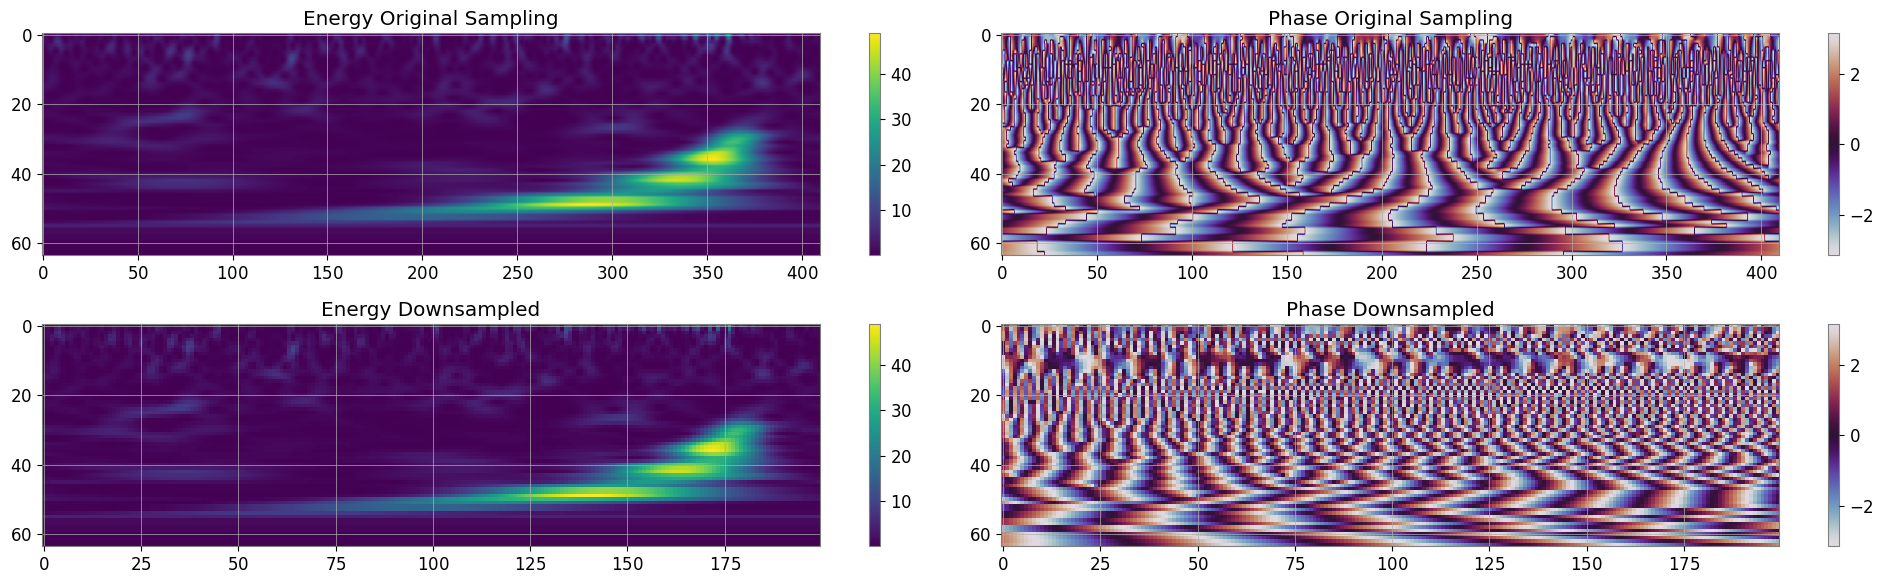

In [184]:
energy_original_sampling=energy_and_phase[0][0][0].detach().cpu()
phase_original_sampling=energy_and_phase[0][0][1].detach().cpu()

energy_downsampled=energy_and_phase_downsampled[0][0][0].detach().cpu()
phase_downsampled=energy_and_phase_downsampled[0][0][1].detach().cpu()


fig, axes= plt.subplots(2,2,figsize=(20,6))

im0=axes[0,0].imshow(np.flipud(energy_original_sampling), aspect='auto')
im1=axes[0,1].imshow(np.flipud(phase_original_sampling), aspect='auto', cmap='twilight')
im2=axes[1,0].imshow(np.flipud(energy_downsampled), aspect='auto')
im3=axes[1,1].imshow(np.flipud(phase_downsampled), aspect='auto', cmap='twilight')

axes[0,0].set_title('Energy Original Sampling')
axes[0,1].set_title('Phase Original Sampling')
axes[1,0].set_title('Energy Downsampled')
axes[1,1].set_title('Phase Downsampled')

fig.colorbar(im0, ax=axes[0,0])
fig.colorbar(im1, ax=axes[0,1])
fig.colorbar(im2, ax=axes[1,0])
fig.colorbar(im3, ax=axes[1,1])

plt.tight_layout()
plt.show()

The function *upsample_freq_domain* upsamples the downsampled image to bring it back to its original time-resolution.

In [185]:
energy_and_phase_reupsampled= upsample_freq_domain(energy_and_phase_downsampled, qtransform, original_time_resolution, preserve_amplitude=True)

We plot the original images with the ones that have been re-upsampled and verify that no information was lost.

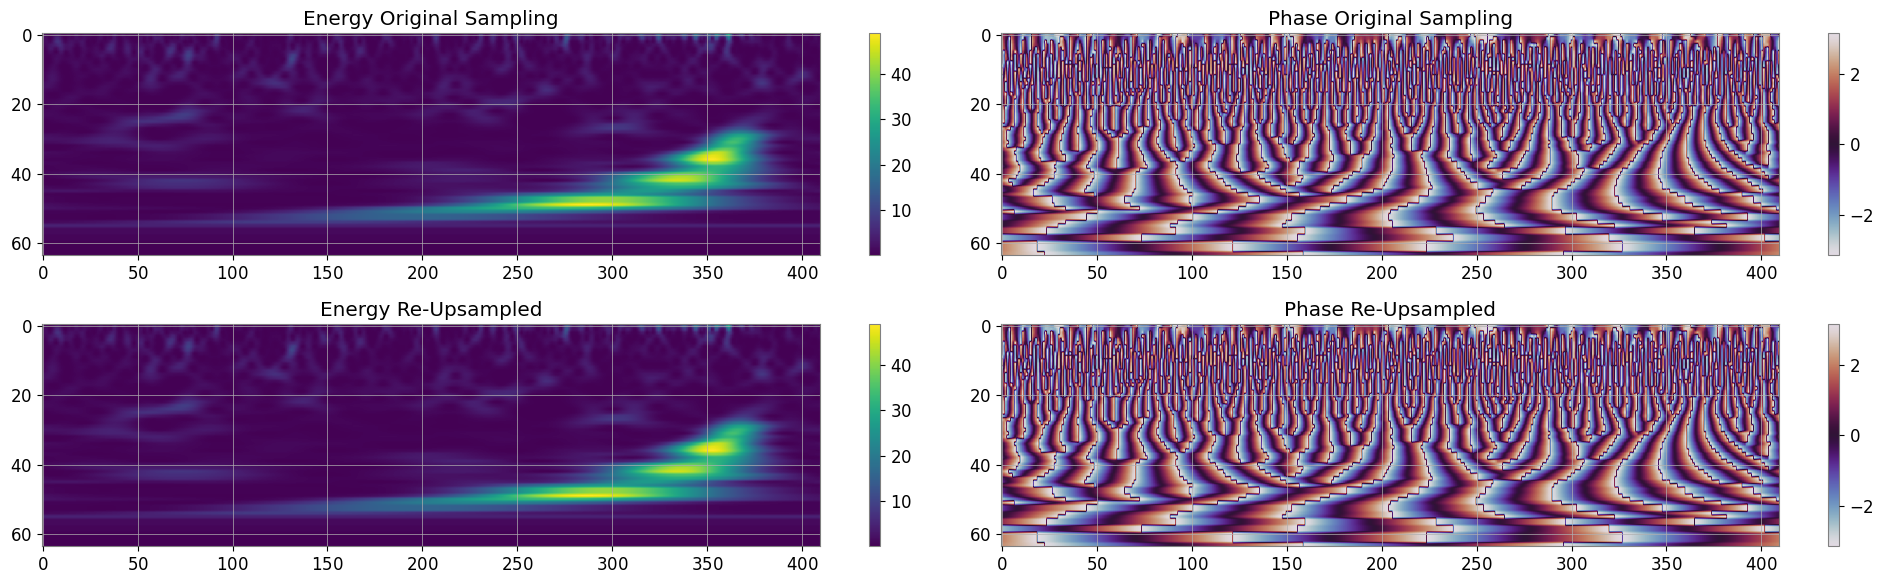

In [186]:
energy_reupsampled=energy_and_phase_reupsampled[0][0][0].detach().cpu()
phase_reupsampled=energy_and_phase_reupsampled[0][0][1].detach().cpu()

fig, axes= plt.subplots(2,2,figsize=(20,6))

im0=axes[0,0].imshow(np.flipud(energy_original_sampling), aspect='auto')
im1=axes[0,1].imshow(np.flipud(phase_original_sampling), aspect='auto', cmap='twilight')
im2=axes[1,0].imshow(np.flipud(energy_reupsampled), aspect='auto')
im3=axes[1,1].imshow(np.flipud(phase_reupsampled), aspect='auto', cmap='twilight')

axes[0,0].set_title('Energy Original Sampling')
axes[0,1].set_title('Phase Original Sampling')
axes[1,0].set_title('Energy Re-Upsampled')
axes[1,1].set_title('Phase Re-Upsampled')

fig.colorbar(im0, ax=axes[0,0])
fig.colorbar(im1, ax=axes[0,1])
fig.colorbar(im2, ax=axes[1,0])
fig.colorbar(im3, ax=axes[1,1])
plt.tight_layout()
plt.show()

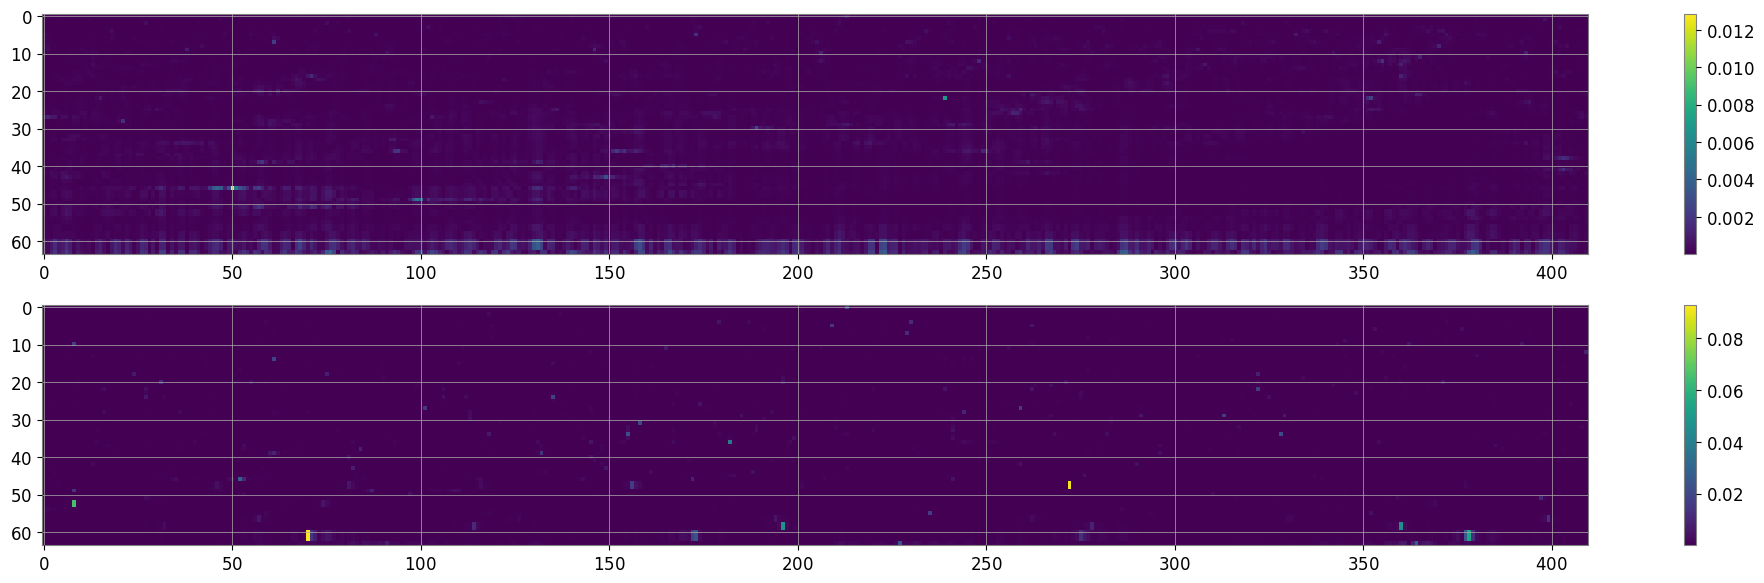

In [66]:
relative_energy_error=torch.abs(energy_original_sampling-energy_reupsampled)/torch.abs(energy_original_sampling)
relative_phase_error=torch.abs(phase_original_sampling-phase_reupsampled)/torch.abs(phase_original_sampling)

fig, axes= plt.subplots(2,1,figsize=(20,6))

im0=axes[0].imshow(np.flipud(relative_energy_error), aspect='auto')
im1=axes[1].imshow(np.flipud(relative_phase_error), aspect='auto')

fig.colorbar(im0, ax=axes[0])
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

In [187]:
inverted_timeseries=qtransform.invert_qtransform(energy_and_phase_reupsampled.detach().cpu(),idx=None, 
                        energy_mode=energy_mode,
                        phase_mode=phase_mode,
                        polar_mode=polar_mode,
                        complex_mode=complex_mode)

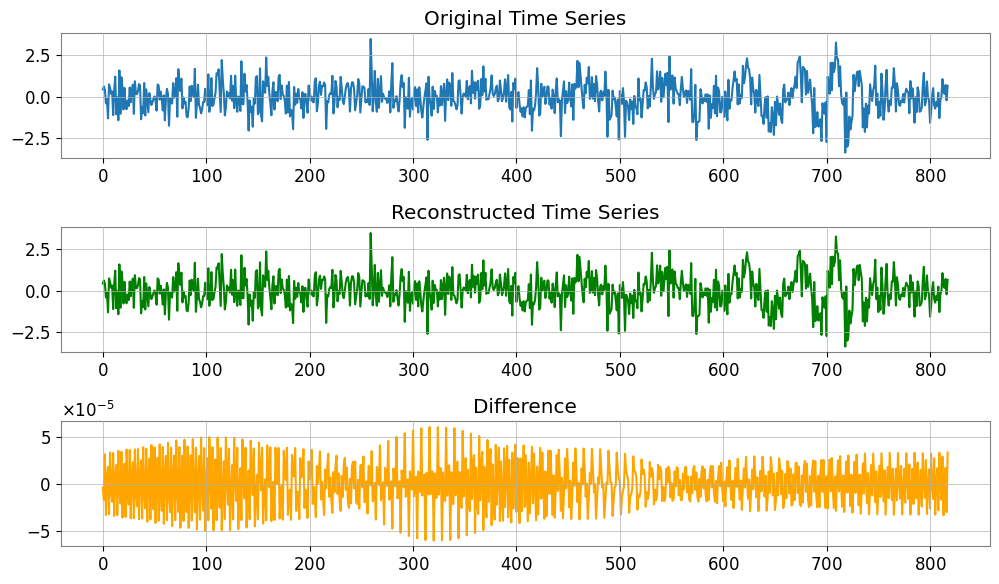

In [188]:
diff=inverted_timeseries[0][0]-GW_whitened.to('cpu')

fig, axes=plt.subplots(3,1,figsize=(10,6))
axes[0].plot(inverted_timeseries[0][0])
axes[1].plot(GW_whitened.detach().cpu(), color='green')
axes[2].plot(diff, color='orange')

axes[0].set_title('Original Time Series')
axes[1].set_title('Reconstructed Time Series')
axes[2].set_title('Difference')

plt.tight_layout()
plt.show()

## Study of Different Window Functions to Compute the QTAM

Each Q-Tile **X** with central frequency **f** is computed as $$X_f(\tau, Q)= \int_{-\infty}^{+\infty} x(t)w_f(t-\tau, Q)e^{-2\pi i Q t} dt .$$  
In this section we show the results for different choices of windows: Kaiser window, Hann window, Tukey window and Planck-Taper window. 
We compute and plot each of these windows with diffrent choices of parameters.

The Kaiser window is defined as $$ K_{i}= I_{0} \left( \beta \sqrt ( 1- ( \frac{1-N/2}{N/2} )^{2} ) \right) /I(\beta) .$$ 
With $$I_{0}(x) =\sum_{k=0}^{\infty} \frac{(x^2/4)^{k}}{(k!)^2} $$ being the zeroth Bessel function.

In [ ]:
for beta in [0.1, 0.2, 1.0, 2.0, 4.0, 8.0]:
    w=torch.kaiser_window(50, beta=beta, periodic=False, device='cpu', dtype=torch.float64)
    w = w / torch.sqrt(torch.mean(w**2)).item()
    plt.plot(w, label='beta= '+str(beta))
    plt.title('Kaiser Windows')
    plt.legend()

The Hann window is defined as $$ w[n]= \sin^{2} \left( \frac{\pi n}{N-1} \right) $$, where N is the full window size.

In [ ]:
hann_window = torch.hann_window(50, periodic=False, device='cpu', dtype=torch.float64)
plt.plot(hann_window)
plt.title('Hann Window')

The Tukey window, also known as *cosine tapered window* has expression

\begin{cases}
 w[n] = \frac{1}{2} \left[ 1 - \cos \left(  \frac{2 \pi n}{\alpha N}  \right) \right] & \text{for } 0 \leq n \leq \frac{\alpha N}{2}, \\
w[n] = 1 & \text{for } \frac{\alpha N}{2} < n < \frac{N}{2}, \\
w[N-n]=w[n] & \text{for } 0 \leq n \leq \frac{N}{2}. 
\end{cases}

In [ ]:
for alpha in [0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5]:
    window=tukey_window_range(50, alpha=alpha, norm=True)
    plt.plot(window, label='alpha= '+str(alpha))
    plt.title('Tukey Windows')
    plt.legend()

The Planck-Taper window is defines as
\begin{cases}
w[n] = \left( 1+ \exp( \frac{\epsilon N }{n}- \frac{\epsilon N}{\epsilon N - n} \right)^{-1} & \text{for } 1 \leq n \leq \epsilon N, \\
w[n] = 1 & \text{for } \epsilon N< n < \frac{N}{2}, \\
w[N-n]=w[n] & \text{for } 0 \leq n \leq \frac{N}{2} .
\end{cases}

In [ ]:
for epsilon in [0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5]:
    window=planck_taper_window_range(50, epsilon=epsilon, norm=True, device='cpu')
    plt.plot(window, label='epsilon= '+str(epsilon))
    plt.legend()

We now compute the QTs with different windows and for each window we span a range of parameters.

In [ ]:
import time
import torch
import numpy as np
# Assuming SingleQTransform, duration, f_s, q, frange, data_torch, and device are defined

# --- New Configuration for num_freq ---
num_freq_values = [32, 64, 128, 256]
# --------------------------------------

# Define parameter ranges
tau_range_tukey = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
tau_range_planck = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
beta_range_kaiser = [0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 8.0]

# Structure the base configurations (independent of num_freq)
base_configs = []

# Non-parameter windows
base_configs.append({'window_type': None, 'tau': None, 'beta': None})
base_configs.append({'window_type': 'hann', 'tau': None, 'beta': None})

# Tukey window
for tau in tau_range_tukey:
    base_configs.append({'window_type': 'tukey', 'tau': tau, 'beta': None})

# Planck-taper window (using tau for epsilon)
for tau in tau_range_planck:
    base_configs.append({'window_type': 'planck-taper', 'tau': tau, 'beta': None})

# Kaiser window
for beta in beta_range_kaiser:
    base_configs.append({'window_type': 'kaiser', 'tau': None, 'beta': beta})

# The qtransforms list will now be a list of lists,
# where each inner list holds the 4 results for the same window config.
qtransforms_grouped = []
# We also need a simplified list of names/configs for plotting the row headers
row_configs = []

total_runs = len(base_configs) * len(num_freq_values)
print(f"Testing {total_runs} total window configurations...")

for config in base_configs:
    window_type = config['window_type']
    tau = config['tau']
    beta = config['beta']

    # Determine the configuration name for print/plotting (the row header)
    if window_type == 'tukey':
        name = f"Tukey ($\\tau={tau}$)"
    elif window_type == 'planck-taper':
        name = f"Planck-taper ($\\epsilon={tau}$)"
    elif window_type == 'kaiser':
        name = f"Kaiser ($\\beta={beta}$)"
    elif window_type is None:
        name = "Rectangular (None)"
    else:
        name = str(window_type).capitalize()

    row_configs.append(name)
    current_config_results = []

    for num_freq in num_freq_values:
        # NOTE: Update spectrogram_shape based on num_freq, assuming fixed time axis (384)
        spectrogram_shape = [num_freq, 384]

        # Initialize the QTransform
        qtransform = SingleQTransform(
            duration=duration,
            sample_rate=f_s,
            q=Q,
            spectrogram_shape=spectrogram_shape, # Updated
            qtiles_mode=True,
            energy_mode=True,
            phase_mode=True,
            frange=frange,
            logf=True,
            num_freq=num_freq, # Updated
            window_param=window_type,
            tau=tau,
            beta=beta
        ).to(device)

        start = time.time()
        # The output tensor shape will now depend on num_freq
        energy = qtransform(GW_whitened)
        #, norm=True)
        
        # Store the energy tensor directly, as it has a different shape
        current_config_results.append(energy[0, 0, 0].cpu().numpy())
        
        del energy
        torch.cuda.empty_cache()
        print(f'{name} (num_freq={num_freq}) took: {time.time() - start:.3f}s')

    qtransforms_grouped.append(current_config_results)
# qtransforms_grouped is a list of lists: [[nf32, nf64, nf128, nf256], [nf32, nf64, ...], ...]

Once the QTs are computed in **qtransforms_grouped**, we plot them side by side to show the different effects of the choices.

In [ ]:
# --- Configuration Parameter ---
num_freq_values = [32, 64, 128, 256] # For column headers
PLOTS_PER_ROW = len(num_freq_values)

# -------------------------------

num_base_configs = len(qtransforms_grouped)
num_cols = PLOTS_PER_ROW
num_rows = num_base_configs # Each base config is now a row

# Define common color scale
vmin = 0
vmax = 25

# Create the figure and axes
# Use a smaller aspect ratio for the figure since we have many rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 3 * num_rows), squeeze=False)

# Main Plotting Loop
for row in range(num_rows):
    # Get the results for the current window configuration
    row_results = qtransforms_grouped[row]
    row_name = row_configs[row]

    for col in range(num_cols):
        ax = axes[row, col]
        spectrogram = row_results[col]
        num_freq = num_freq_values[col]

        # Plot the spectrogram
        # The last 'im' object will be used for the colorbar
        im = ax.imshow(np.flipud(spectrogram), aspect='auto')
        #, vmin=vmin, vmax=vmax)

        # Set Row Label (Window Configuration)
        if col == 0:
            ax.set_ylabel(row_name, fontsize=10, weight='bold')
        
        # Set Column Title (num_freq value)
        if row == 0:
            ax.set_title(f"$N_f={num_freq}$", fontsize=12)

        # Set X-axis label only for the bottom row
        if row == num_rows - 1:
            ax.set_xlabel('Time', fontsize=8)
        else:
            # Hide x-axis tick labels for inner rows
            ax.tick_params(axis='x', labelbottom=False)

        # Hide y-axis tick labels for inner columns
        if col > 0:
            ax.tick_params(axis='y', labelleft=False)

# --- Single Colorbar for all plots ---
# Adjust layout to make space for better subplot spacing and the colorbar
fig.subplots_adjust(right=0.92, top=0.9, hspace=0.3, wspace=0.1)
cbar_ax = fig.add_axes([0.94, 0.15, 0.015, 0.7]) # [left, bottom, width, height]

if num_base_configs > 0:
    fig.colorbar(im, cax=cbar_ax, label='Energy (Shared Scale)')
# -------------------------------------

fig.suptitle('Q-Transform Energy Spectrograms: Window Parameters vs. Frequency Bins ($N_f$)', fontsize=16)
#plt.tight_layout(rect=[0, 0, 0.92, 1]) # Final layout adjustment
plt.tight_layout(rect=[0, 0, 0.92, 0.98]) # Final layout adjustment - right=0.92 reserved for colorbar, top=0.96 reserved for suptitle

#plt.savefig('qt_window_test.pdf') # Removed, as you had it commented out
plt.show()